/home/joao/anaconda3/envs/PlantsSM/lib/python3.7/site-packages/dask/core.py:119: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  return func(*(_execute_task(a, cache) for a in args))


KeyboardInterrupt: 

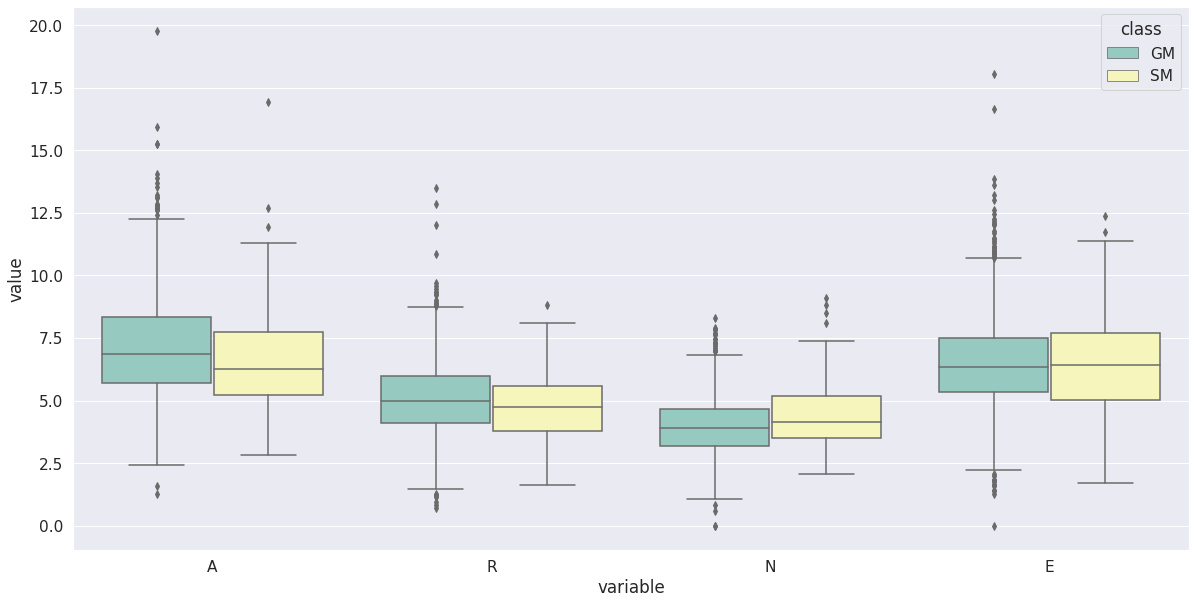

In [2]:


from plants_sm.unsupervised.tsne import SklearnTSNE
from plants_sm.unsupervised.pca import SklearnPCA
import numpy as np
from sklearn.preprocessing import StandardScaler
from plants_sm.data_exploration.boxplot import Boxplot
from plants_sm.data_structures.dataset import PandasDataset

dataset2 = PandasDataset(labels_field=["class"],
                         representation_field="sequence_test",
                         instances_ids_field="gene", features_fields=slice(8, -1))
dataset2.from_csv("../data/train_set.tsv")

scaler = StandardScaler()
data = scaler.fit_transform(dataset2.features)

tsne = SklearnTSNE()
tsne_data = tsne.fit_transform(data)
tsne.generate_dotplot(tsne_data, dataset2.labels[:, 0])
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, roc_auc_score


def train_and_test(model, train_data, train_labels, test_data, test_labels):
    model.fit(train_data, train_labels)
    predictions = model.predict(test_data)

    cnf_matrix = confusion_matrix(test_labels, predictions)

    print(cnf_matrix)

    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)

    FP = FP.astype(float)
    print('FP: ' + str(FP))
    FN = FN.astype(float)
    print('Fn: ' + str(FN))
    TP = TP.astype(float)
    print('FN: ' + str(FN))
    TN = TN.astype(float)
    print('TN: ' + str(TN))
    # false positive rate
    FPR = FP / (FP + TN)
    print('FPR: ' + str(FPR))
    # False negative rate
    FNR = FN / (TP + FN)
    print('FNR: ' + str(FNR))

    print(classification_report(test_labels, predictions))
    print(f1_score(test_labels, predictions, average="binary"))
    print(recall_score(test_labels, predictions, average="binary"))
    print(precision_score(test_labels, predictions, average="binary"))
    print(roc_auc_score(test_labels, predictions))
    print()
    return model


dataset2 = PandasDataset(labels_field=["class"],
                         representation_field="sequence_test",
                         instances_ids_field="gene", features_fields=slice(8, -1))
dataset2.from_csv("../data/train_set.tsv")
dataset_test = PandasDataset(labels_field=["class"],
                             representation_field="sequence_test",
                             instances_ids_field="gene", features_fields=slice(8, -1))
dataset_test.from_csv("../data/test_set.tsv")
scaler = StandardScaler()
data = scaler.fit_transform(dataset2.features)

data_test = scaler.transform(dataset_test.features)
# Model evaluation
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

train_labels = np.select([dataset2.labels[:, 0] == "SM", dataset2.labels[:, 0] == "GM"], [1, 0], dataset2.labels[:, 0])

test_labels = np.select([dataset_test.labels[:, 0] == "SM", dataset_test.labels[:, 0] == "GM"], [1, 0],
                        dataset_test.labels[:, 0])

param_space = {"bootstrap": [True, False],
               "max_depth": [6, 8, 10, 12, 14],
               "max_features": ['auto', 'sqrt', 'log2'],
               "min_samples_leaf": [2, 3, 4],
               "min_samples_split": [2, 3, 4, 5],
               "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
               "class_weight": [{0: 1, 1: 8}]
               }

forest_clf = RandomForestClassifier(class_weight={0: 1, 1: 8})

for i in range(3, 10):
    print("Number of Folds: ", i)
    forest_rand_search = RandomizedSearchCV(forest_clf, param_space, n_iter=30,
                                            scoring="f1", verbose=True, cv=i,
                                            n_jobs=8, random_state=42)
    model = train_and_test(forest_rand_search, data, train_labels.astype('int'), data_test, test_labels.astype('int'))

#model = KNeighborsClassifier(n_neighbors=5, weights="distance")
#model = SVC(C=2,kernel="sigmoid", class_weight={0:1, 1: 8})
#model = train_and_test(forest_rand_search, data, train_labels.astype('int'), data_test, test_labels.astype('int'))

In [11]:
from collections import Counter

dataset_test = PandasDataset(labels_field=["class"],
                             representation_field="sequence_test",
                             instances_ids_field="gene", features_fields=slice(8, -1))
dataset_test.from_csv("../data/test_set.tsv")

dataset_all_predicted = PandasDataset(labels_field=["union class", "Aracyc class"],
                         representation_field="sequence_test",
                         instances_ids_field="gene", features_fields=slice(8, None))

dataset_all_predicted.from_csv("../data/dados_propythia.csv")


dataframe = dataset_all_predicted.dataframe
df = dataframe[dataframe["gene"].isin(dataset_test.identifiers)]

Counter(df["union class"])


/home/joao/anaconda3/envs/PlantsSM/lib/python3.7/site-packages/dask/core.py:119: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  return func(*(_execute_task(a, cache) for a in args))


Counter({'GM-GM': 117, 'GM-SM': 45, 'SM-SM': 16, 'SM-GM': 4})